# Killifish osmotic tolerance data QC

### Background

Salinity is an environmental factor that plays an important role in the spatial and temporal distribution of marine organisms. Killifish have evolved a range of physiologies in response to environmental osmotic fluctuations, with some species being tolerant to only a narrow salinity range (stenohaline) while others are tolerant to a wide salinity range (euryhaline) ([Whitehead 2010](https://whiteheadresearch.files.wordpress.com/2012/05/whitehead-2010-evolution.pdf)). Colonization and adaptation to freshwater environments has happened several times during the evolutionary history of these fish. While the molecular mechanisms of osmoregulation in response to salinity change has been characterized in Fundulus heteroclitus ([Brennan et al. 2016](http://jeb.biologists.org/content/218/8/1212)), the conservative trends and unity of genes involved with adaptation to freshwater are not known. By comparing the gene expresssion profiles of multiple species in response to the same osmotic challenge experiment, we can get a better idea for the evolutionary history of genes associated with this osmotic tolerance phenotype and adaptation to salinity change in multiple species of killifish.

### Experiment

Fish were collected and kept at UC Davis in their native salinities. Individuals from each species were acclimated for 6 days in either fresh water (n=3), brackish water (n=3), or brackish water then transferred to fresh water for 24 hrs (n=3). Fresh water was sabilized at 0.2 ppt while brackish water was 15 ppt.  

The following species were used for the experiment, followed by the numbers of individuals that survived the experiment and were sequenced (RNA-seq):

```
A_xenica               9
F_catanatus            7
F_chrysotus            8
F_diaphanus            7
F_grandis              9
F_heteroclitus.MDPL    9
F_heteroclitus.MDPP    9
F_notatus              9
F_notti                2
F_olivaceous           8
F_parvapinis           8
F_rathbuni             9
F_sciadicus            5
F_similis              9
F_zebrinus             4
L_goodei               9
L_parva                9
```

## Problem

Based on SNP calling from aligning reads to the Fundulus heteroclitus genome, Noah Reid noticed that some of the samples may be contaminated with each other.

## Question: do we need to remove these samples from the de novo transcriptome assemblies, and downstream DE analysis?

These samples have already been removed from the de novo assemblies:

* F_sciadicus_BW_2 may be F_chrysotus (this has already been removed from F. sciadicus assembly)
* F_diaphanus_FW_1 may be F_heteroclitus (this has already been removed from F. diaphanus assembly)

These samples still need to be addressed:

* F_zebrinus_BW_2 is contaminated by F_sciadicus_BW_2 (which is actually a mislabeled F. chrysotus)
* F_catanatus_FW_1 is contaminated by a heteroclitus sample. Perhaps F_heteroclitus_MDPP_BW_1
"the mixture is about 5:1 catanatus/heteroclitus. I am not as certain of the exact contaminating sample here, but it does seem to be MDPP heteroclitus."

* F_parvapinis_transfer_1 and F_parvapinis_FW_1 are contaminated by heteroclitus, probably MDPP.
* F_heteroclitus_MDPP_transfer_3 clusters very clearly with MDPL , specifically F_heteroclitus_MDPL_transfer_3

The following are unsure:

* “F_notatus_transfer_3” contaminated by heteroclitus
* “F_rathbuni_transfer_3” contaminated by heteroclitus
* "F_notatus_FW_2" contaminated by heteroclitus
* "L_goodei_BW_3" contaminated by L. parva
* "L_parva_transfer_3" contaminated by parvipinnis

In [1]:
%matplotlib inline
import numpy
import scipy
import pylab
import scipy.cluster.hierarchy as sch

The [sourmash](http://sourmash.readthedocs.io/en/latest/) software allows us to calculate MinHash sketches from fastq files, compare and plot the results ([Brown and Irber 2016](http://joss.theoj.org/papers/3d793c6e7db683bee7c03377a4a7f3c9)). MinHash is a technique described in [Ondov et al. 2016](http://biorxiv.org/content/early/2016/04/19/029827). By examining the [jaccard distance](https://en.wikipedia.org/wiki/Jaccard_index) between readsets based on k-mer analysis - not alignment - we can get an estimate for how similar the reads are to each other. This allows us to see how samples are grouped together based on raw k-mer content, and may tell us whether some samples are contaminated with each other. [This method could be used as an alignment-free, and fast, way to QC reads](https://twitter.com/RobLanfear/status/847365687311966209).

The following analysis is an exploration with sourmash to qc RNAseq reads from the killifish osmotic tolerance dataset. 

Steps of sourmash, see script: [https://github.com/ljcohen/osmotic/blob/master/denovo_assembly_scripts/sourmash.py]

* Trim low abundance k-mers from adapter-trimmed reads. These will (likely) be sequencing errors. It is unlikely that trimmed k-mers will be rare variants because even if a variant is rare, it will still be expressed at some coverage greater than a low abundance k-mer.

```
trim-low-abund.py -k 21 -C 2 --variable-coverage *.trim.fq
```

* Run sourmash compute on the .trimabund files:

```
sourmash compute --force -k 21 --scaled 20000 *.trimabund.fq
```

This will produce one .sig file for each *.trimabund.fq. Scaling value of 2000 was used, which takes the same number of k-mers from each sample.


In [6]:
# functions to load the comparison matrix and plot figures

def load_matrix_and_labels(basefile):
    D = numpy.load(open(basefile, 'rb'))
    labeltext = [ x.strip() for x in open(basefile + '.labels.txt') ]
    return (D, labeltext)

def plot_composite_matrix(D, labeltext, show_labels=True, show_indices=True,vmax=1.0):
    if show_labels:
        show_indices=True
    D = numpy.array(D, copy=True)

    fig = pylab.figure(figsize=(16,28))
    ax1 = fig.add_axes([0.09,0.1,0.2,0.6])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)

    # plot dendrogram
    Y = sch.linkage(D, method='single') # centroid  
    
    dendrolabels = labeltext
    if not show_labels:
        dendrolabels = [ str(i) for i in range(len(labeltext)) ]
                        
    Z1 = sch.dendrogram(Y, orientation='right', labels=dendrolabels,
                        no_labels=not show_indices)
    ax1.set_xticks([])

    xstart = 0.45
    width = 0.45
    if not show_labels:
        xstart = 0.315
    scale_xstart = xstart + width + 0.01

    # plot matrix
    axmatrix = fig.add_axes([xstart,0.1, width,0.6])

    # (this reorders D by the clustering in Z1)
    idx1 = Z1['leaves']
    D = D[idx1, :]
    D = D[:, idx1]

    # show matrix
    im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=pylab.cm.YlGnBu, vmin=0, vmax=vmax)
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])

    # Plot colorbar.                                                            
    axcolor = fig.add_axes([scale_xstart,0.1,0.02,0.6])
    pylab.colorbar(im, cax=axcolor)
    
    # print labels, if not shown
    if not show_labels:
        for i, label in enumerate(labeltext):
            print('%d\t%s' % (i, label))

    return fig

In [32]:
!sourmash compare abundtrim_no_track_abundance/*.sig --ksize 21 -o killifish.npy > /dev/null && echo success || echo fail

# running sourmash subcommand: compare
loading abundtrim_no_track_abundance/A_xenica_BW_1.trim_1P.fq.abundtrim.sig
loading abundtrim_no_track_abundance/A_xenica_BW_1.trim_2P.fq.abundtrim.sig
loading abundtrim_no_track_abundance/A_xenica_BW_2.trim_1P.fq.abundtrim.sig
loading abundtrim_no_track_abundance/A_xenica_BW_2.trim_2P.fq.abundtrim.sig
loading abundtrim_no_track_abundance/A_xenica_BW_3.trim_1P.fq.abundtrim.sig
loading abundtrim_no_track_abundance/A_xenica_BW_3.trim_2P.fq.abundtrim.sig
loading abundtrim_no_track_abundance/A_xenica_FW_1.trim_1P.fq.abundtrim.sig
loading abundtrim_no_track_abundance/A_xenica_FW_1.trim_2P.fq.abundtrim.sig
loading abundtrim_no_track_abundance/A_xenica_FW_2.trim_1P.fq.abundtrim.sig
loading abundtrim_no_track_abundance/A_xenica_FW_2.trim_2P.fq.abundtrim.sig
loading abundtrim_no_track_abundance/A_xenica_FW_3.trim_1P.fq.abundtrim.sig
loading abundtrim_no_track_abundance/A_xenica_FW_3.trim_2P.fq.abundtrim.sig
loading abundtrim_no_track_abundance/A_xenica_tra

In [33]:
D_filename = 'killifish.npy'

In [34]:
D, labeltext = load_matrix_and_labels(D_filename)

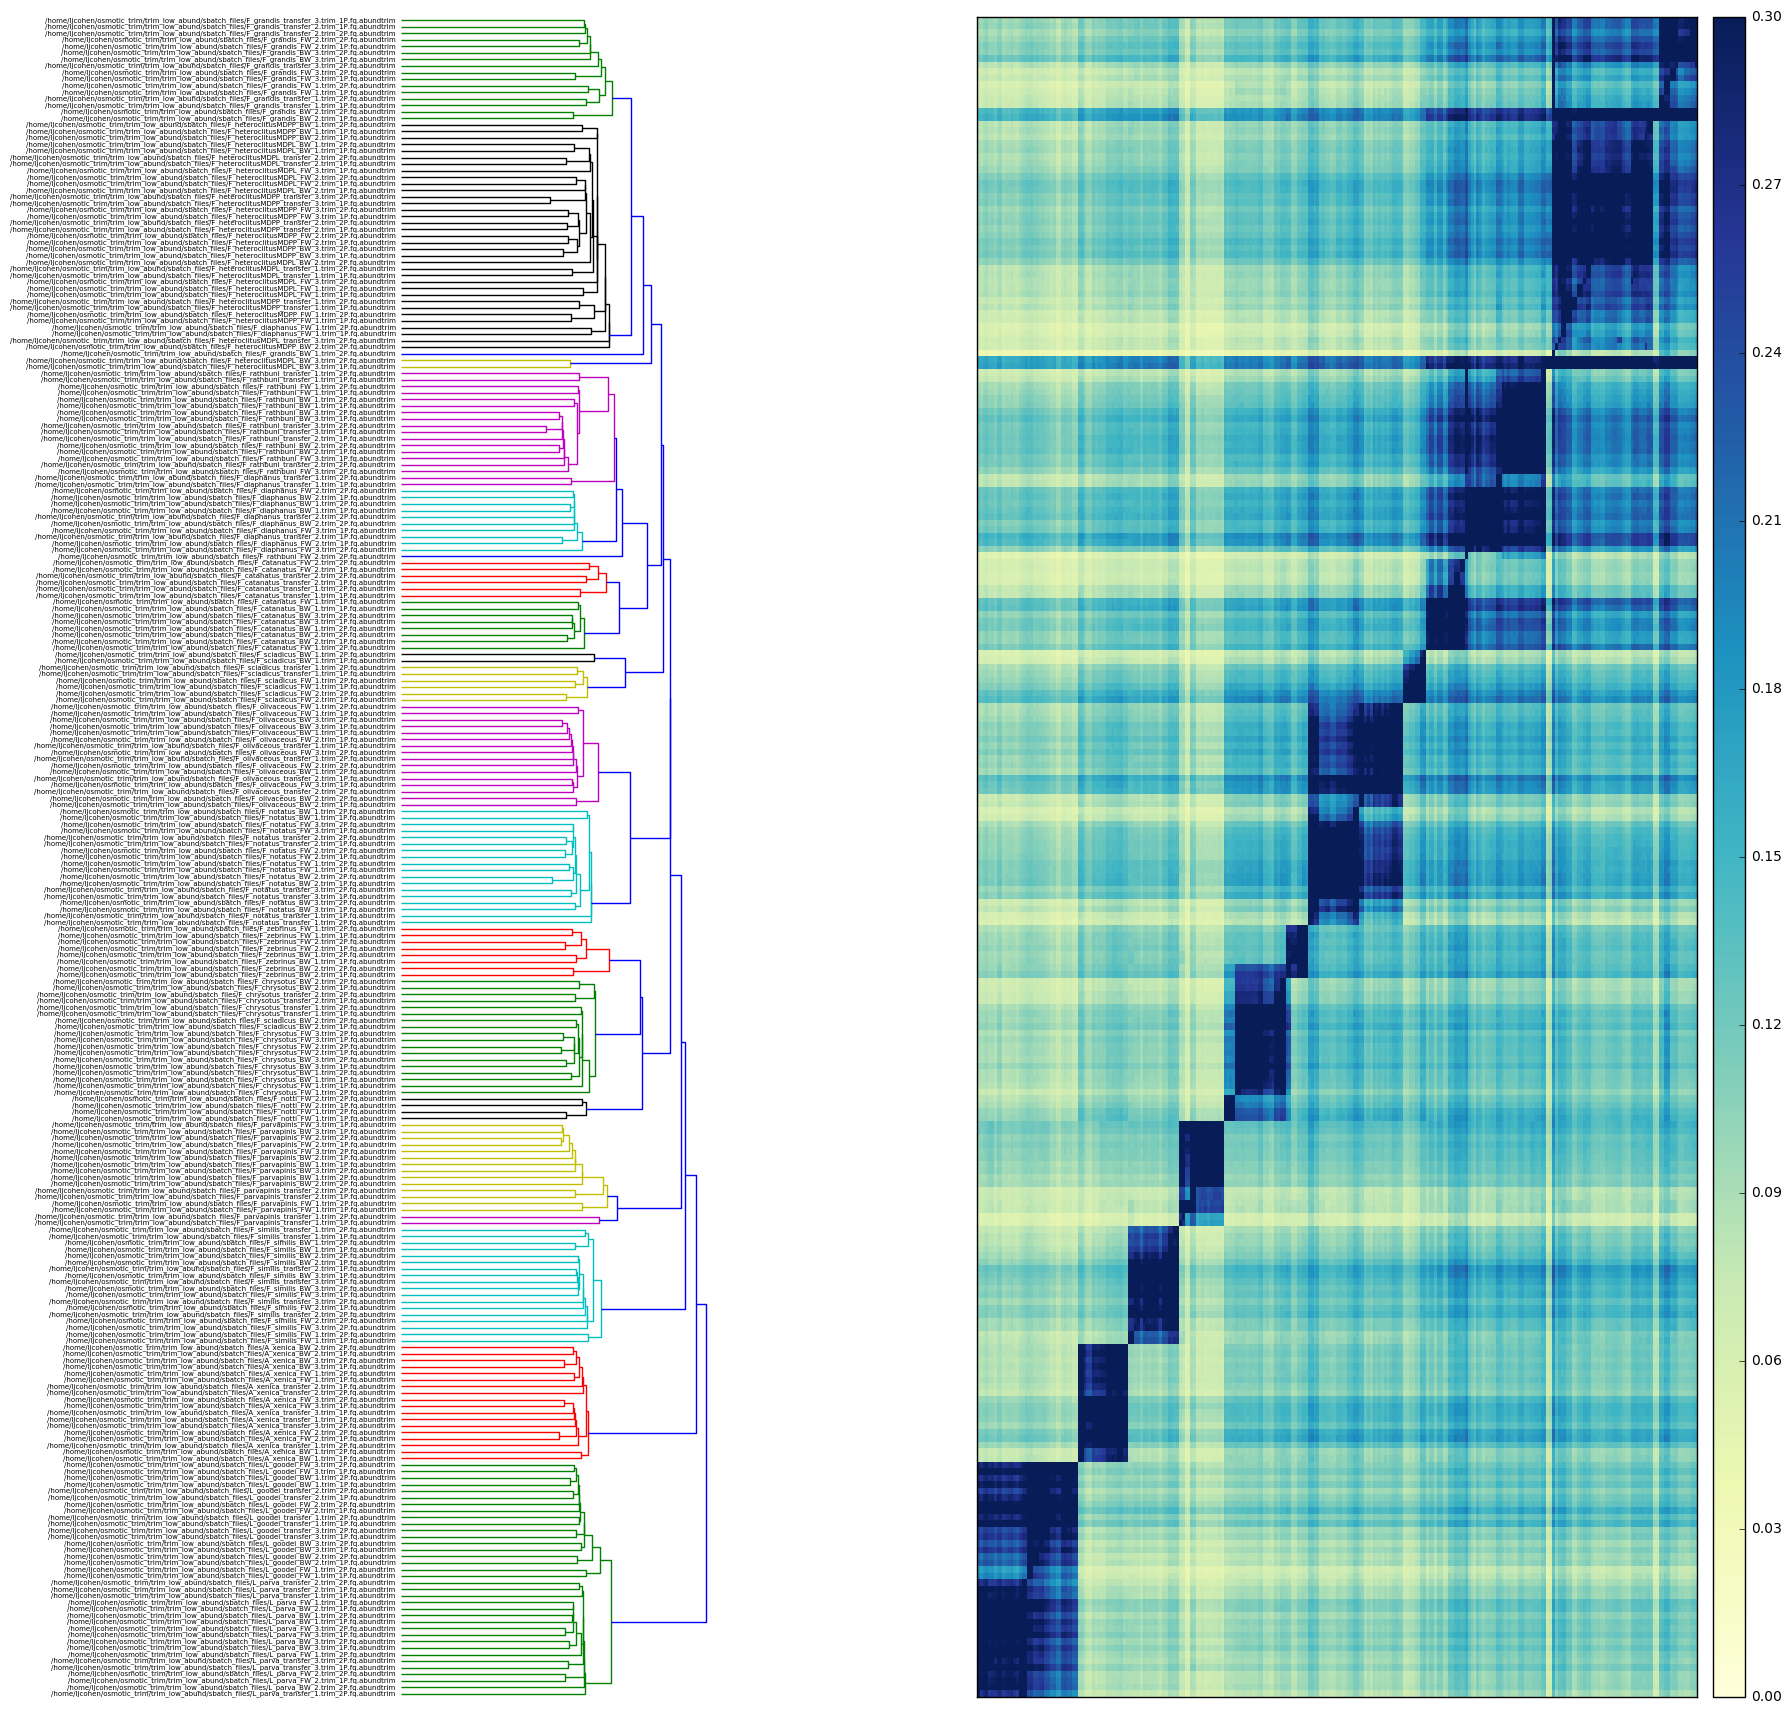

In [37]:
plot_composite_matrix(D, labeltext,vmax=0.3)
pylab.savefig('sourmash-killifish.png')
pylab.savefig('sourmash-killifish.pdf')

The above plot has a lot of noise (even after playing with vmax, the distance parameter). Some samples look weird, e.g. F_heteroclitusMDPL_BW_3, F_grandis_BW_2. But really hard to tell if this is meaningful signal.

Some thoughts from Titus on 3/20:

* What is the average nucleotide identity between species?
* Unsymmetrical, see https://github.com/dib-lab/sourmash/pull/150
* Use a bigger k-mer size, change sourmash to k=51 to achieve max distance of separation 
* Some species are more closely related than others. This may contribute to some of the noise? Since jaccard distance (intersection over union) is A intersect B divided by A union B. If A and B (species 1 and species 2) are more closely related by nucleotide similarity than another A and B (species 1 and species 5) will this skew our results? 
* try `trim-low-abund.py` ([http://khmer.readthedocs.io/en/latest/user/scripts.html]) without `--variable-coverage`. This only trims low abundance k-mers from sequences with high coverage. By not using this, we will just trim low abundance kmers regardless of whether the sequence is high abundance or not.

Ran sourmash compute on *.trimabund.fq with larger k=51:

```
head  -n 4000000 {}  | sourmash compute -k 51 --name {} --scaled 500 --dna - -o {}{}.sig
```

In [40]:
#!sourmash compare k_51_head/{*.sig,*.sub} --ksize 51 -o killifish.npy > /dev/null && echo success || echo fail
!sourmash compare abundtrim_k_51_head/*.sig --ksize 51 -o killifish.npy > /dev/null && echo success || echo fail

# running sourmash subcommand: compare
loading abundtrim_k_51_head/A_xenica_BW_1_1P.fq.abundtrim.sig
loading abundtrim_k_51_head/A_xenica_BW_1_2P.fq.abundtrim.sig
loading abundtrim_k_51_head/A_xenica_BW_2_1P.fq.abundtrim.sig
loading abundtrim_k_51_head/A_xenica_BW_2_2P.fq.abundtrim.sig
loading abundtrim_k_51_head/A_xenica_BW_3_1P.fq.abundtrim.sig
loading abundtrim_k_51_head/A_xenica_BW_3_2P.fq.abundtrim.sig
loading abundtrim_k_51_head/A_xenica_FW_1_1P.fq.abundtrim.sig
loading abundtrim_k_51_head/A_xenica_FW_1_2P.fq.abundtrim.sig
loading abundtrim_k_51_head/A_xenica_FW_2_1P.fq.abundtrim.sig
loading abundtrim_k_51_head/A_xenica_FW_2_2P.fq.abundtrim.sig
loading abundtrim_k_51_head/A_xenica_FW_3_1P.fq.abundtrim.sig
loading abundtrim_k_51_head/A_xenica_FW_3_2P.fq.abundtrim.sig
loading abundtrim_k_51_head/A_xenica_transfer_1_1P.fq.abundtrim.sig
loading abundtrim_k_51_head/A_xenica_transfer_1_2P.fq.abundtrim.sig
loading abundtrim_k_51_head/A_xenica_transfer_2_1P.fq.abundtrim.sig
loading abund

In [41]:
D_filename2 = 'killifish.npy'

In [42]:
D2, labeltext2 = load_matrix_and_labels(D_filename2)

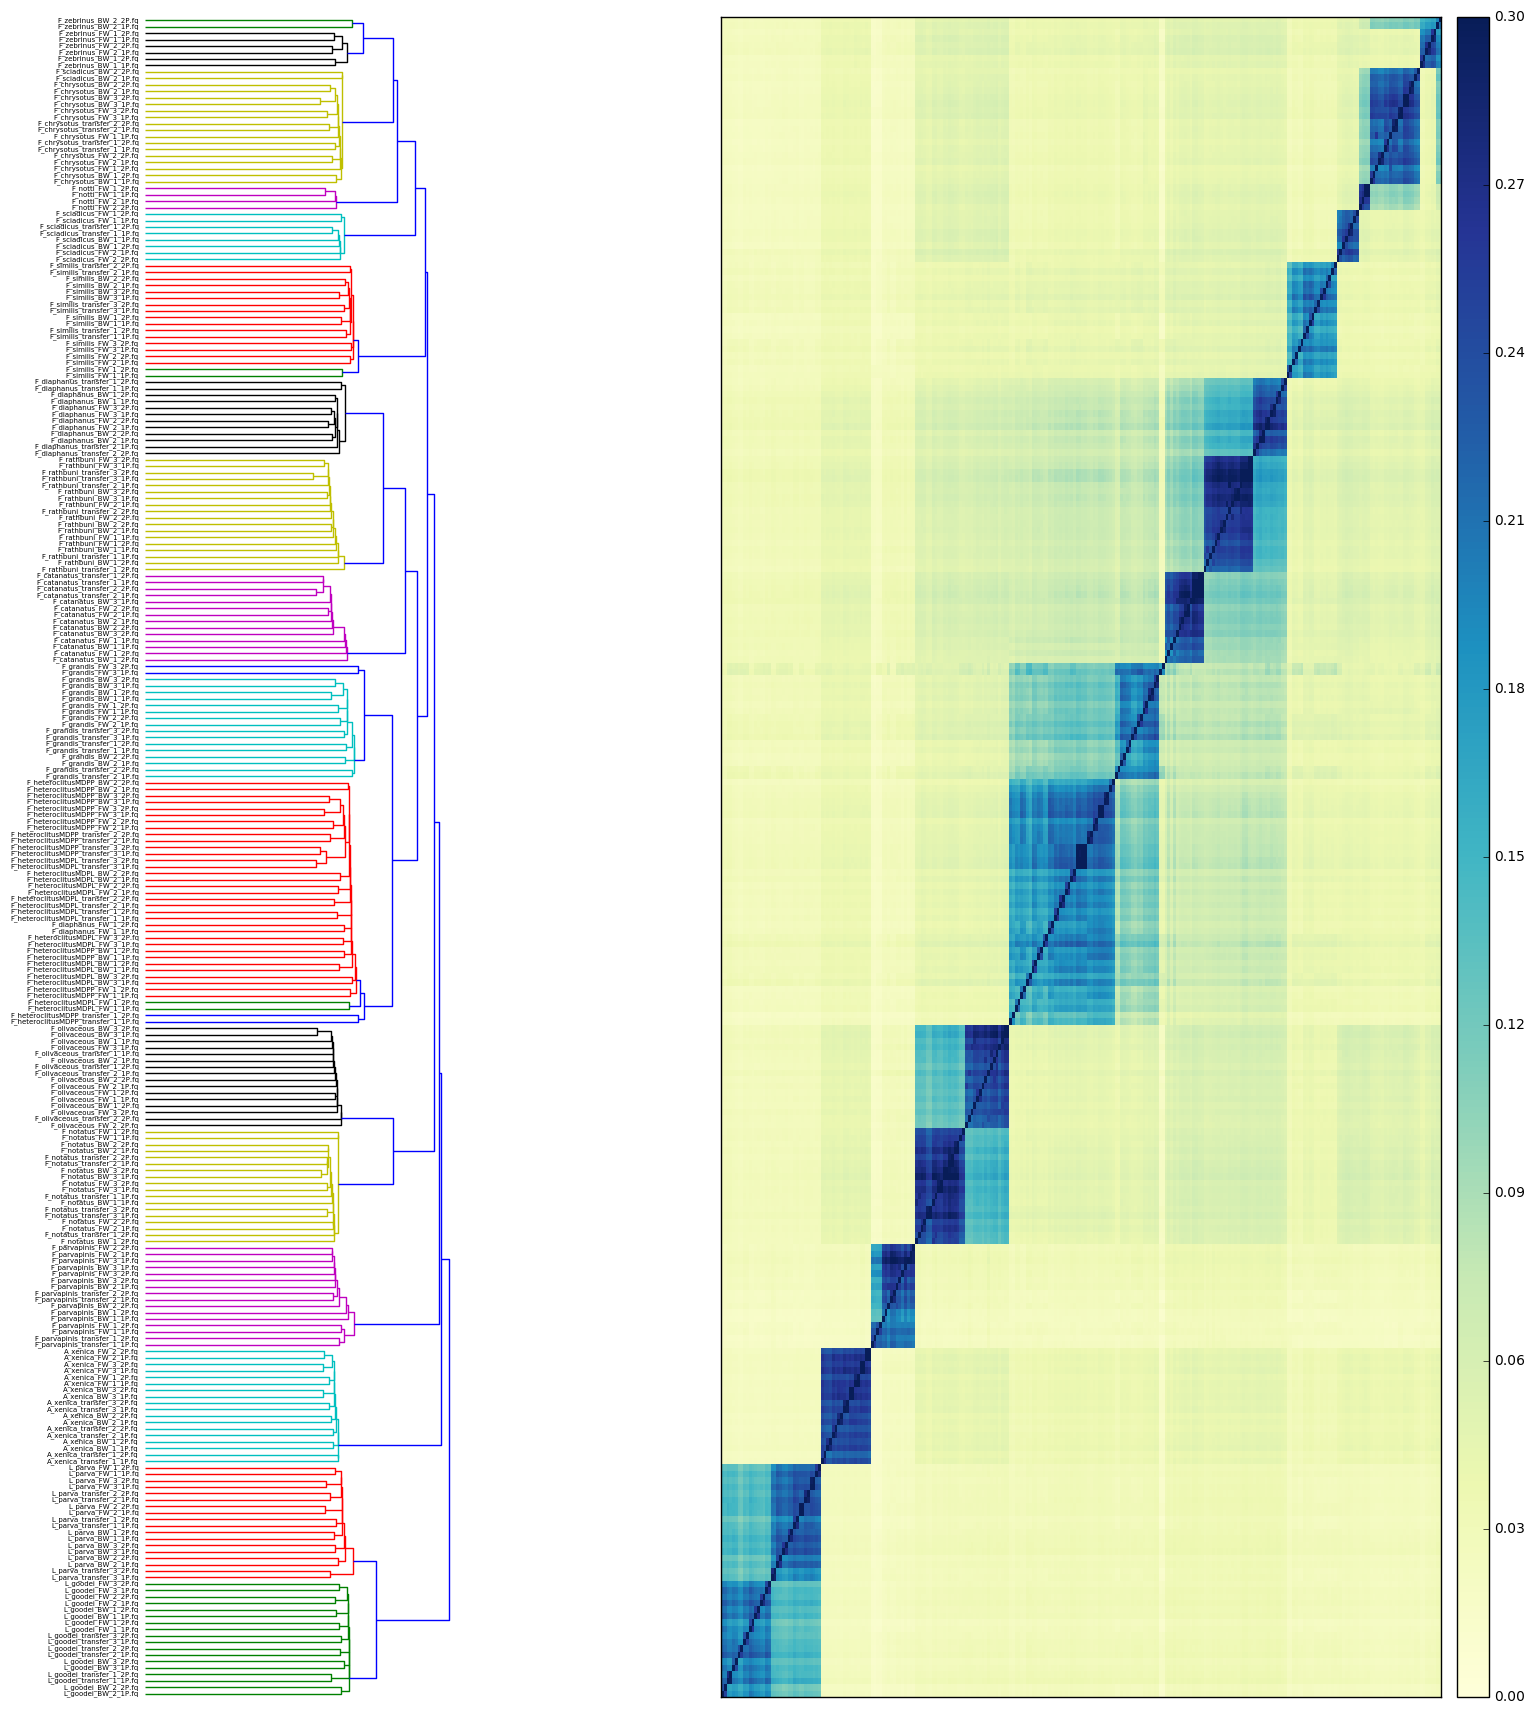

In [44]:
plot_composite_matrix(D2, labeltext2,vmax=0.3)
pylab.savefig('sourmash-killifish_k51.png')
pylab.savefig('sourmash-killifish_51.pdf')

* The matrix above still has some noise, but shows that k=51 gives a much cleaner signal compared to k=21. By looking at unique kmers of length k=51 in each sample compared to other samples, this gives us a more conservative comparisons.
* Talking to Titus, clustering dendrogram doesn't mean much, focus on the similarity matrix.
* Confirmed F_sciadicus_BW_2 (actually F_chrysotus) and F_diaphanus_FW_1 (actually F_heteroclitus_MDPL), which Noah had long ago suspected were mislabeled samples. These are still strongly grouped with F_chrysotus and F_heteroclitus_MDPL.
* Looks weird: **F_zebrinus_BW_2**, **F_grandis_FW_3**, **F_parvapinis_transfer_1**
* Some of the **F_heteroclitus_MDPP** appear to be mixed in with **F_heteroclitus_MDPL**
* In general, **F_grandis** and **F_heteroclitus** samples are noisier compared to other species.

To confirm what we observe in the matrix above, Titus had an idea to write a script for looking at each weird sample:

1. pick a set of trusted samples that are similar, e.g. all other F_zebrinus samples compared to F_zebrinus_BW_2
2. Subtract untrusted k-mers from trusted k-mers -> .sub file
3. Use .sub file as a comparison

This is the command to run the script:
```
python subtract.py abundtrim_k_51_head/F_zebrinus_BW_2_1P.fq.abundtrim.sig abundtrim_k_51_head/F_zebrinus_FW_1_1P.fq.abundtrim.sig abundtrim_k_51_head/F_zebrinus_FW_2_1P.fq.abundtrim.sig abundtrim_k_51_head/F_zebrinus_FW_1_2P.fq.abundtrim.sig abundtrim_k_51_head/F_zebrinus_FW_2_2P.fq.abundtrim.sig abundtrim_k_51_head/F_zebrinus_BW_1_1P.fq.abundtrim.sig abundtrim_k_51_head/F_zebrinus_BW_1_2P.fq.abundtrim.sig
```

In the following, we will search for the subtracted kmers in the neighboring samples and display the similarity with the neighboring samples:

In [29]:
!sourmash search abundtrim_k_51_head/*.sub abundtrim_k_51_head/F_chry*.sig abundtrim_k_51_head/F_zeb* --ksize 51

# running sourmash subcommand: search
loaded query: F_zebrinus_BW_2_1P.fq... (k=51, DNA)
loading db of signatures from 25 files
excluding query from database (file k_51_head/F_zebrinus_BW_2_1P.fq.abundtrim.sig.sub)
loaded 24 signatures total.
18 matches; showing 3:
	 F_zebrinus_BW_2_1P.fq 	 1.000 	 k_51_head/F_zebrinus_BW_2_1P.fq.abundtrim.sig
	 F_chrysotus_BW_3_1P.fq 	 0.127 	 k_51_head/F_chrysotus_BW_3_1P.fq.abundtrim.sig
	 F_chrysotus_BW_3_2P.fq 	 0.126 	 k_51_head/F_chrysotus_BW_3_2P.fq.abundtrim.sig


In the above, the subtracted k-mers from F_zebrinus_BW_2_1P.fq are ~12% similar to F_chrysotus_BW_3, and no other F_zebrinus or F_chrysotus.

Below, we will compare F_zebrinus_BW_2 to F_grandis k-mers. (No matches)

In [31]:
!sourmash search abundtrim_k_51_head/*.sub abundtrim_k_51_head/F_grand* --ksize 51

# running sourmash subcommand: search
loaded query: F_zebrinus_BW_2_1P.fq... (k=51, DNA)
loading db of signatures from 18 files
loaded 18 signatures total.
** no matches in 18 signatures


Run this on other suspected samples.

In [45]:
!python subtract.py abundtrim_k_51_head/F_grandis_FW_3_1P.fq.abundtrim.sig abundtrim_k_51_head/F_grandis_BW_1_1P.fq.abundtrim.sig abundtrim_k_51_head/F_grandis_BW_1_2P.fq.abundtrim.sig abundtrim_k_51_head/F_grandis_BW_2_1P.fq.abundtrim.sig abundtrim_k_51_head/F_grandis_BW_2_2P.fq.abundtrim.sig abundtrim_k_51_head/F_grandis_BW_3_1P.fq.abundtrim.sig abundtrim_k_51_head/F_grandis_BW_3_2P.fq.abundtrim.sig abundtrim_k_51_head/F_grandis_FW_1_1P.fq.abundtrim.sig abundtrim_k_51_head/F_grandis_FW_1_2P.fq.abundtrim.sig abundtrim_k_51_head/F_grandis_FW_2_1P.fq.abundtrim.sig abundtrim_k_51_head/F_grandis_FW_2_2P.fq.abundtrim.sig abundtrim_k_51_head/F_grandis_transfer_1_1P.fq.abundtrim.sig abundtrim_k_51_head/F_grandis_transfer_1_2P.fq.abundtrim.sig abundtrim_k_51_head/F_grandis_transfer_2_1P.fq.abundtrim.sig abundtrim_k_51_head/F_grandis_transfer_2_2P.fq.abundtrim.sig abundtrim_k_51_head/F_grandis_transfer_3_1P.fq.abundtrim.sig abundtrim_k_51_head/F_grandis_transfer_3_2P.fq.abundtrim.sig 

loading abundtrim_k_51_head/F_grandis_FW_3_1P.fq.abundtrim.sig
subtracting abundtrim_k_51_head/F_grandis_BW_1_1P.fq.abundtrim.sig
subtracting abundtrim_k_51_head/F_grandis_BW_1_2P.fq.abundtrim.sig
subtracting abundtrim_k_51_head/F_grandis_BW_2_1P.fq.abundtrim.sig
subtracting abundtrim_k_51_head/F_grandis_BW_2_2P.fq.abundtrim.sig
subtracting abundtrim_k_51_head/F_grandis_BW_3_1P.fq.abundtrim.sig
subtracting abundtrim_k_51_head/F_grandis_BW_3_2P.fq.abundtrim.sig
subtracting abundtrim_k_51_head/F_grandis_FW_1_1P.fq.abundtrim.sig
subtracting abundtrim_k_51_head/F_grandis_FW_1_2P.fq.abundtrim.sig
subtracting abundtrim_k_51_head/F_grandis_FW_2_1P.fq.abundtrim.sig
subtracting abundtrim_k_51_head/F_grandis_FW_2_2P.fq.abundtrim.sig
subtracting abundtrim_k_51_head/F_grandis_transfer_1_1P.fq.abundtrim.sig
subtracting abundtrim_k_51_head/F_grandis_transfer_1_2P.fq.abundtrim.sig
subtracting abundtrim_k_51_head/F_grandis_transfer_2_1P.fq.abundtrim.sig
subtracting abundtrim_k_51_head/F_grandis_transf

In [46]:
!sourmash search abundtrim_k_51_head/F_grandis_FW_3_1P.fq.abundtrim.sig.sub abundtrim_k_51_head/F_grand* --ksize 51

# running sourmash subcommand: search
loaded query: F_grandis_FW_3_1P.fq... (k=51, DNA)
loading db of signatures from 19 files
excluding query from database (file abundtrim_k_51_head/F_grandis_FW_3_1P.fq.abundtrim.sig.sub)
loaded 18 signatures total.
1 matches; showing 3:
	 F_grandis_FW_3_1P.fq 	 1.000 	 abundtrim_k_51_head/F_grandis_FW_3_1P.fq.abundtrim.sig


In [47]:
!sourmash search abundtrim_k_51_head/F_grandis_FW_3_1P.fq.abundtrim.sig.sub abundtrim_k_51_head/F_het* --ksize 51

# running sourmash subcommand: search
loaded query: F_grandis_FW_3_1P.fq... (k=51, DNA)
loading db of signatures from 36 files
loaded 36 signatures total.
** no matches in 36 signatures


In [48]:
!python subtract.py abundtrim_k_51_head/F_parvapinis_transfer_1_1P.fq.abundtrim.sig abundtrim_k_51_head/F_parvapinis_BW* abundtrim_k_51_head/F_parvapinis_FW* abundtrim_k_51_head/F_parvapinis_transfer_2* 

loading abundtrim_k_51_head/F_parvapinis_transfer_1_1P.fq.abundtrim.sig
subtracting abundtrim_k_51_head/F_parvapinis_BW_1_1P.fq.abundtrim.sig
subtracting abundtrim_k_51_head/F_parvapinis_BW_1_2P.fq.abundtrim.sig
subtracting abundtrim_k_51_head/F_parvapinis_BW_2_1P.fq.abundtrim.sig
subtracting abundtrim_k_51_head/F_parvapinis_BW_2_2P.fq.abundtrim.sig
subtracting abundtrim_k_51_head/F_parvapinis_BW_3_1P.fq.abundtrim.sig
subtracting abundtrim_k_51_head/F_parvapinis_BW_3_2P.fq.abundtrim.sig
subtracting abundtrim_k_51_head/F_parvapinis_FW_1_1P.fq.abundtrim.sig
subtracting abundtrim_k_51_head/F_parvapinis_FW_1_2P.fq.abundtrim.sig
subtracting abundtrim_k_51_head/F_parvapinis_FW_2_1P.fq.abundtrim.sig
subtracting abundtrim_k_51_head/F_parvapinis_FW_2_2P.fq.abundtrim.sig
subtracting abundtrim_k_51_head/F_parvapinis_FW_3_1P.fq.abundtrim.sig
subtracting abundtrim_k_51_head/F_parvapinis_FW_3_2P.fq.abundtrim.sig
subtracting abundtrim_k_51_head/F_parvapinis_transfer_2_1P.fq.abundtrim.sig
subtracting 

In [49]:
!sourmash search abundtrim_k_51_head/F_parvapinis_transfer_1_1P.fq.abundtrim.sig.sub abundtrim_k_51_head/F_parvapinis* --ksize 51

# running sourmash subcommand: search
loaded query: F_parvapinis_transfer_1_1P.fq... (k=51, DNA)
loading db of signatures from 17 files
excluding query from database (file abundtrim_k_51_head/F_parvapinis_transfer_1_1P.fq.abundtrim.sig.sub)
loaded 16 signatures total.
1 matches; showing 3:
	 F_parvapinis_transfer_1_1P.fq 	 1.000 	 abundtrim_k_51_head/F_parvapinis_transfer_1_1P.fq.abundtrim.sig


In [50]:
!sourmash search abundtrim_k_51_head/F_parvapinis_transfer_1_1P.fq.abundtrim.sig.sub abundtrim_k_51_head/F_het* --ksize 51

# running sourmash subcommand: search
loaded query: F_parvapinis_transfer_1_1P.fq... (k=51, DNA)
loading db of signatures from 36 files
loaded 36 signatures total.
** no matches in 36 signatures
